<a href="https://colab.research.google.com/github/ahmadSum1/PythonRobotics/blob/skb_test/Localization/extended_kalman_filter/TTK33_EKF_IEKF_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTK33_EKF_IEKF_Assignment by Sakib Ahmed

"""

Extended kalman filter (EKF) and Iterated kalman filter (iEKF) localization for asynchronus sensors

author: Sakib Ahmed (@ahmadSum1)
modified/extended upon Atsushi Sakai (@Atsushi_twi) 's implementation

"""

In [72]:
# Library imports

# import sys
# import pathlib
# sys.path.append(str(pathlib.Path(__file__).parent.parent.parent))

import math
# import matplotlib
# matplotlib.use('GTK3Agg')
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
# from enum import auto
import numpy as np
np.random.seed(0)

from scipy.spatial.transform import Rotation as Rot

In [73]:
## rotation function
def rot_mat_2d(angle):
    """
    Create 2D rotation matrix from an angle

    Parameters
    ----------
    angle :

    Returns
    -------
    A 2D rotation matrix
    """
    return Rot.from_euler('z', angle).as_matrix()[0:2, 0:2]


In [74]:

# Covariance for EKF simulation
Q = np.diag([
              0.1,              # variance of location on x-axis
              0.1,              # variance of location on y-axis
              np.deg2rad(1.0),  # variance of yaw angle
              1.0               # variance of velocity
              ]) ** 2           # predict state covariance

R = (5.0 * np.diag([1.0, 1.0])) ** 2  # Observation x,y position covariance

#  Simulation parameter
ODOM_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
GPS_NOISE = np.diag([0.25, 0.25]) ** 2

f_odom = 100 #measurement frequency of velocity and yaw rate
f_gps = 1 #measurement frequency of position

DT = 1/f_odom  # time tick [s]

# Genarate the trajectory for "real" path 
here I could use the formula from the matlab page to "compute" velocity using,

`v= r 2 ( ˙ ϕ R + ˙ ϕ L )` and vehicle heading angular velocity `ω= r 2d ( ˙ ϕ R − ˙ ϕ L )`

Would essentially be the same, hence i am using constant velocity and yaw rate for path genaration.


In [75]:
def calc_input(ccw=True):
    
    v = 1.0  # [m/s]
    if ccw:
        yawrate = 0.1  # [rad/s]
    else:
        yawrate = -0.1  # [rad/s]
    u = np.array([[v], [yawrate]])
    return u

In [76]:

def observation_IMU_Odom(xdr, u):
    
    # add noise to input
    ud = u + ODOM_NOISE @ np.random.randn(2, 1)  #gaussian noise

    xdr = motion_model(xdr, ud)  #dead rekoning position

    return xdr, ud

def observation_z(xTrue):
    
    # add noise to gps x-y
    z = observation_model(xTrue) + GPS_NOISE @ np.random.randn(2, 1)

    return z



def motion_model(x, u):
    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[DT * np.cos(x[2, 0]), 0],
                  [DT * np.sin(x[2, 0]), 0],
                  [0.0, DT],
                  [1.0, 0.0]])

    x = F @ x + B @ u

    return x


def observation_model(x):
    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    z = H @ x

    return z


def jacob_f(x, u):
    """
    Jacobian of Motion Model

    motion model
    x_{t+1} = x_t+v*dt*cos(yaw)
    y_{t+1} = y_t+v*dt*sin(yaw)
    yaw_{t+1} = yaw_t+omega*dt
    v_{t+1} = v{t}
    so
    dx/dyaw = -v*dt*sin(yaw)
    dx/dv = dt*cos(yaw)
    dy/dyaw = v*dt*cos(yaw)
    dy/dv = dt*sin(yaw)
    """
    yaw = x[2, 0]
    v = u[0, 0]
    jF = np.array([
        [1.0, 0.0, -DT * v * np.sin(yaw), DT * np.cos(yaw)],
        [0.0, 1.0, DT * v * np.cos(yaw), DT * np.sin(yaw)],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])

    return jF


def jacob_h():
    # Jacobian of Observation Model its just ones since GPS directly gives us our states(positions), so essentially no lineraization.
    jH = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    return jH
    

# Helper function to show the growth of co-varience. 
Kept as it is from the original author.

In [96]:
def plot_covariance_ellipse(xEst, PEst): 
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * np.pi + 0.1, 0.1)
    a = np.sqrt(eigval[bigind])
    b = np.sqrt(eigval[smallind])
    x = [a * np.cos(it) for it in t]
    y = [b * np.sin(it) for it in t]
    angle = np.arctan2(eigvec[1, bigind], eigvec[0, bigind])
    fx = rot_mat_2d(angle) @ (np.array([x, y]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")


# EKF

In [78]:
def EKF_main(SIM_TIME=2.0, show_animation=False, show_covarience=False):
    print("EKF start!!")

    # time = 0.0

    # State Vector X=[x y yaw v]'
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)

    xDR = np.zeros((4, 1))  # Dead reckoning

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hz = np.zeros((2, 1))
    z = np.zeros((2, 1))

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(1, 1, 1)

    for k in range(int(SIM_TIME / DT)):

        # calculate/update real trjectory/pose every 10ms
        u = calc_input()  # * np.array([[1],[0]]) #real movement

        if k > SIM_TIME / DT / 2:  # change direction
            u = calc_input(ccw=False)

        xTrue = motion_model(xTrue, u)  # true position

        xDR, ud = observation_IMU_Odom(xDR, u)  # ud = measured movement/input; xDR = dead reckoning position, nothing to do with ekf, just for comparison;

        #  Predict
        xPred = motion_model(xEst, ud)  #previous state + input = current state(predicted)
        jF = jacob_f(xEst, ud)         
        PPred = jF @ PEst @ jF.T + Q  # P is covariace matrix of the state,

        # at GPS measurement freq
        if k % int(f_odom / f_gps) == 0:
            z = observation_z(xTrue)  # GPS data
            #  Update
            jH = jacob_h()
            zPred = observation_model(xPred)
            y = z - zPred
            S = jH @ PPred @ jH.T + R
            K = PPred @ jH.T @ np.linalg.inv(S)

            xEst = xPred + K @ y
            PEst = (np.eye(len(xEst)) - K @ jH) @ PPred  # P is covariace matrix of the state,
        else:                                            
                            #(Fossen, 2021, sec. 13.4.4 Modification for Asynchronous Measurement Data)
            xEst = xPred
            PEst = PPred

        # store data history
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.hstack((hz, z))

        # ax.set_xlim(auto=True)
        ax.cla()
        ax.plot(hz[0, :], hz[1, :], ".g", label="GPS")
        ax.plot(
            hxTrue[0, :].flatten(), hxTrue[1, :].flatten(), "-b", label="Ground Truth"
        )
        ax.plot(
            hxDR[0, :].flatten(), hxDR[1, :].flatten(), "-k", label="Dead Reckoning"
        )
        ax.plot(
            hxEst[0, :].flatten(),
            hxEst[1, :].flatten(),
            color="purple",
            ls="--",
            lw=1,
            marker="s",
            markerfacecolor="red",
            markersize=2,
            label="EKF",
        )

        if show_covarience:
            plot_covariance_ellipse(xEst, PEst)

        ax.axis("equal")
        ax.grid(True)
        ax.legend(loc="upper left")
        ax.set_title("Time = {:.2f}s".format(k * DT), fontsize="small", loc="left")
        if show_animation:
            # plt.pause(0.001)
            display(fig)

            clear_output(wait=True)
            # plt.pause(0.001)

    # display(fig)

# iEKF

In [79]:
def iEKF_main(SIM_TIME=2.0, show_animation=False, show_covarience=False, max_iter=10, tol = 1e-10):
    print("iEKF start!!")

    # State Vector X=[x y yaw v]'
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)

    xDR = np.zeros((4, 1))  # Dead reckoning

    # define tolerance
    e = tol

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hz = np.zeros((2, 1))
    z = np.zeros((2, 1))

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(1, 1, 1)

    iter_hist = []

    for k in range(int(SIM_TIME / DT)):

        # calculate/update real trjectory/pose every 10ms
        u = calc_input()  # * np.array([[1],[0]]) #real movement

        if k > SIM_TIME / DT / 2:  # change direction
            u = calc_input(ccw=False)

        xTrue = motion_model(xTrue, u)  # true position

        xDR, ud = observation_IMU_Odom(xDR, u)  # ud = measured movement/input; xDR = dead reckoning position, nothing to do with ekf, just for comparison;

        #  Predict
        xPred = motion_model(xEst, ud)
        jF = jacob_f(xEst, ud)
        PPred = jF @ PEst @ jF.T + Q  # P is covariace matrix of the state,

        # at GPS measurement freq
        if k % int(f_odom / f_gps) == 0:
            z = observation_z(xTrue)  # GPS data
            #  Update

            # % initialize iterator using state estimation
            eta = xPred
            eta_l = np.zeros_like(eta)
            iter = 1

            while (np.linalg.norm(eta_l - eta, np.inf) / np.linalg.norm(eta_l, np.inf) >= e) and (iter <= max_iter):

                # % save old eta at begin of loop, except at first iretation
                if iter != 0:
                    eta = eta_l

                jH = jacob_h()
                zPred = observation_model(eta)
                y = z - zPred
                S = jH @ PPred @ jH.T + R
                K = PPred @ jH.T @ np.linalg.inv(S)

                eta_l = xPred + K @ (y-jH@(xPred-eta)) # eq 63 from slide
                iter = iter + 1
            iter_hist.append(iter - 1)

            xEst = eta_l
            PEst = (np.eye(len(xEst)) - K @ jH) @ PPred  # P is covariace matrix of the state,

        else:
            xEst = xPred
            PEst = PPred

        # store data history
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.hstack((hz, z))

        # ax.set_xlim(auto=True)
        ax.cla()
        ax.plot(hz[0, :], hz[1, :], ".g", label="GPS")
        ax.plot(
            hxTrue[0, :].flatten(), hxTrue[1, :].flatten(), "-b", label="Ground Truth"
        )
        ax.plot(
            hxDR[0, :].flatten(), hxDR[1, :].flatten(), "-k", label="Dead Reckoning"
        )
        ax.plot(
            hxEst[0, :].flatten(),
            hxEst[1, :].flatten(),
            color="purple",
            ls="-",
            lw=1,
            marker="s",
            markerfacecolor="red",
            markersize=2,
            label="iEKF",
        )

        if show_covarience:
            plot_covariance_ellipse(xEst, PEst)

        ax.axis("equal")
        ax.grid(True)
        ax.legend(loc="upper left")
        ax.set_title("Time = {:.2f}s".format(k * DT), fontsize="small", loc="left")
        if show_animation:
            # plt.pause(0.001)
            display(fig)

            clear_output(wait=True)
            # plt.pause(0.001)

    print("Number of iterations per update: \n",iter_hist)  # for debug


In [93]:
run_time = 5.2 #seconds
#default noise
ODOM_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
GPS_NOISE = np.diag([0.25, 0.25]) ** 2

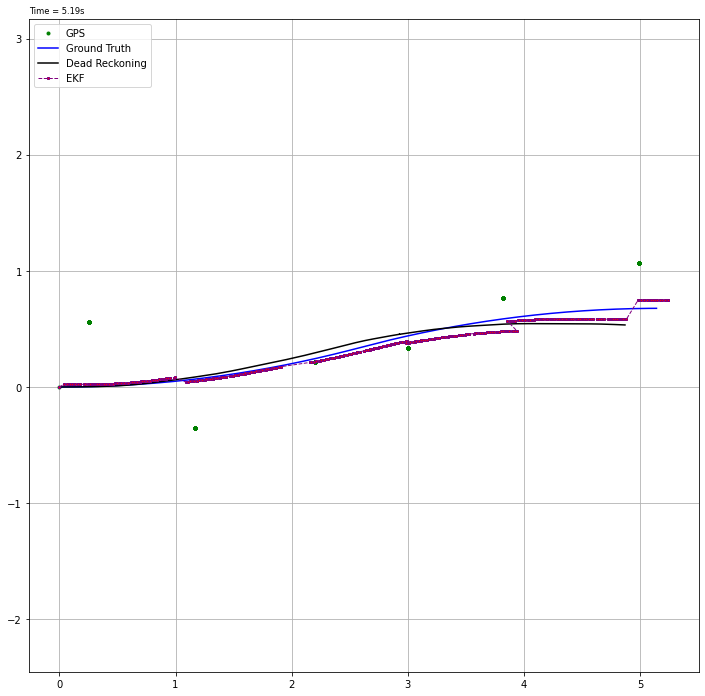

In [81]:
np.random.seed(0)
EKF_main(SIM_TIME = run_time, show_animation = True, show_covarience = False)

Number of iterations per update: 
 [1, 1, 1, 1, 1, 1]


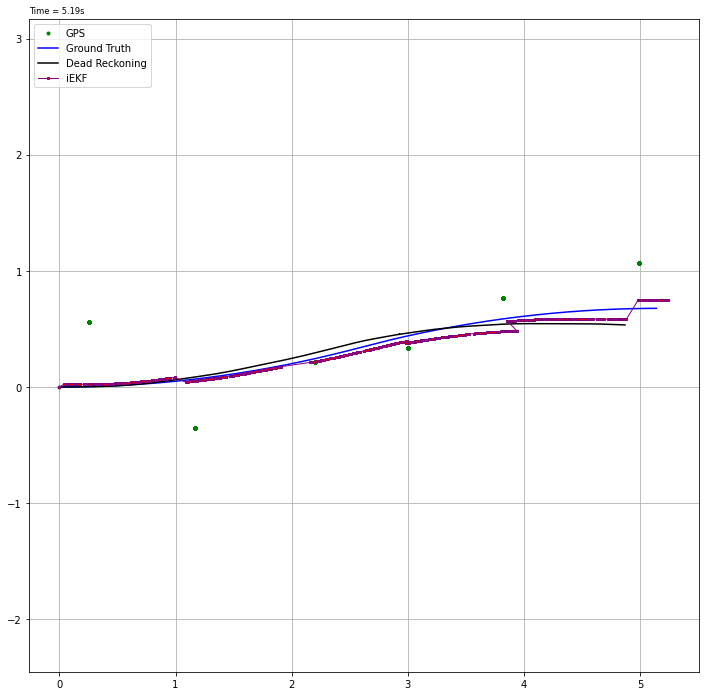

In [82]:
np.random.seed(0)
iEKF_main(SIM_TIME = run_time, show_animation = True, show_covarience = False, max_iter=1) #should be same as "just ekf"

Number of iterations per update: 
 [2, 2, 2, 2, 2, 2]


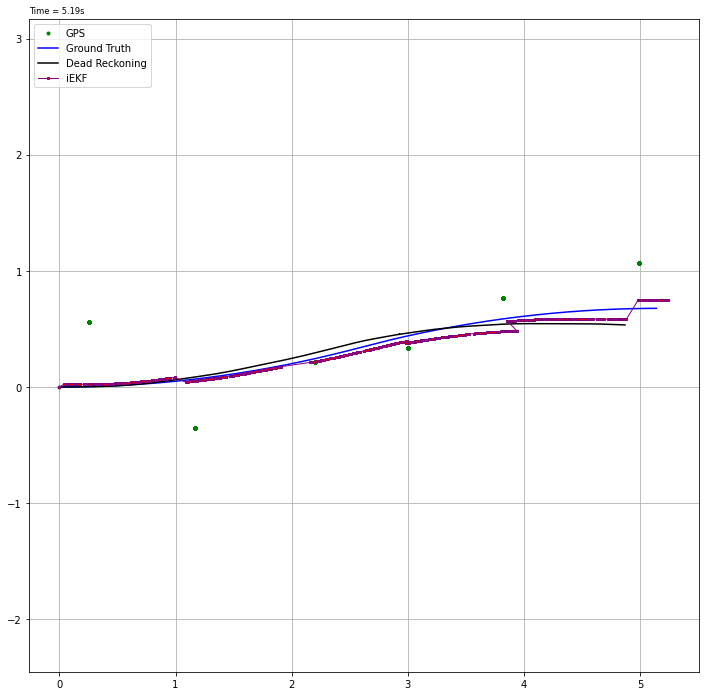

In [83]:
np.random.seed(0)
iEKF_main(SIM_TIME = run_time, show_animation = True, show_covarience = False, max_iter=100)

# lets change noise level
"Implement the EKF and present the effect of ***increasing noise in angular rate and linear accceleration*** as well as in position measurements."

In [84]:
run_time = 5.2 #seconds
#default noise
ODOM_NOISE = np.diag([1.5, np.deg2rad(60.0)]) ** 2
# GPS_NOISE = np.diag([0.25, 0.25]) ** 2

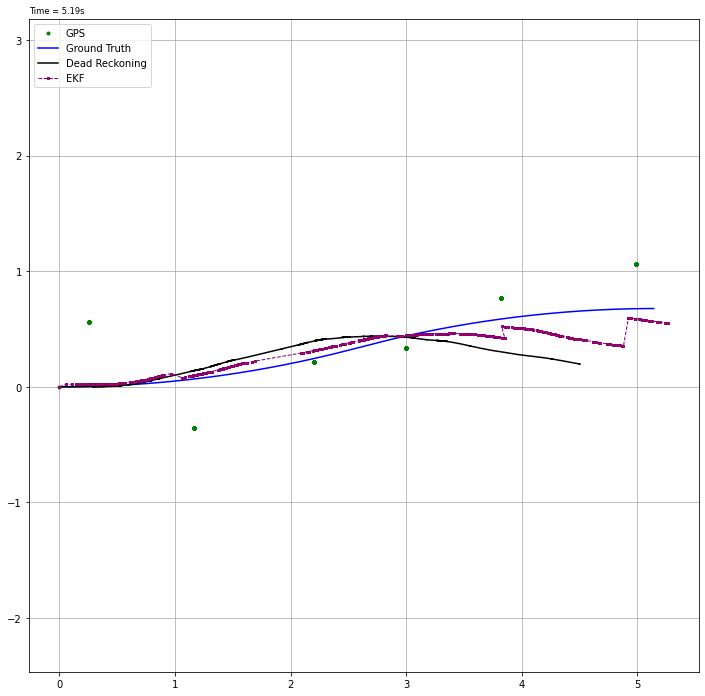

In [85]:
np.random.seed(0)
EKF_main(SIM_TIME = run_time, show_animation = True, show_covarience = False)

Number of iterations per update: 
 [2, 2, 2, 2, 2, 2]


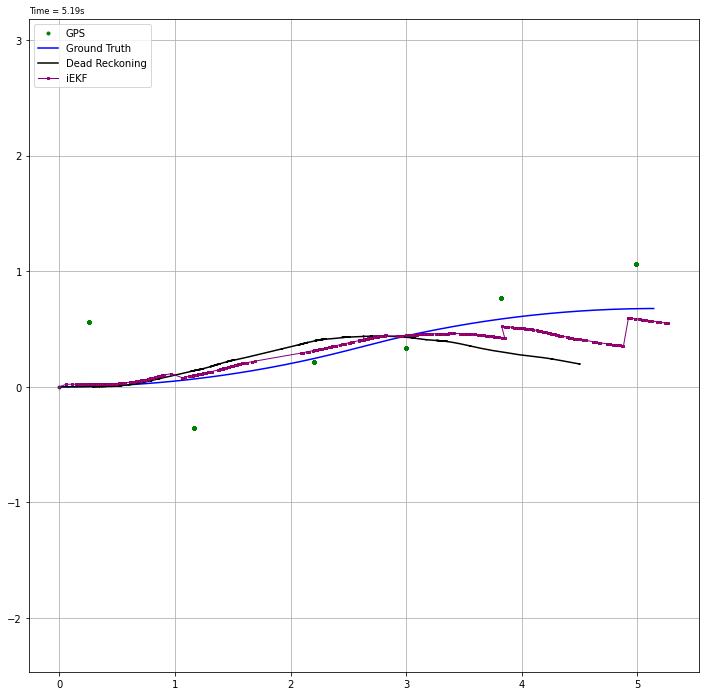

In [86]:
np.random.seed(0)
iEKF_main(SIM_TIME = run_time, show_animation = True, show_covarience = False, max_iter=100)

# lets change noise level for gps (without adjusting R(trust in gps))
"Implement the EKF and present the effect of increasing noise in angular rate and linear accceleration as well as in **position measurements**."

In [87]:
run_time = 5.2 #seconds
#default noise
ODOM_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
GPS_NOISE = np.diag([0.75, 0.75]) ** 2

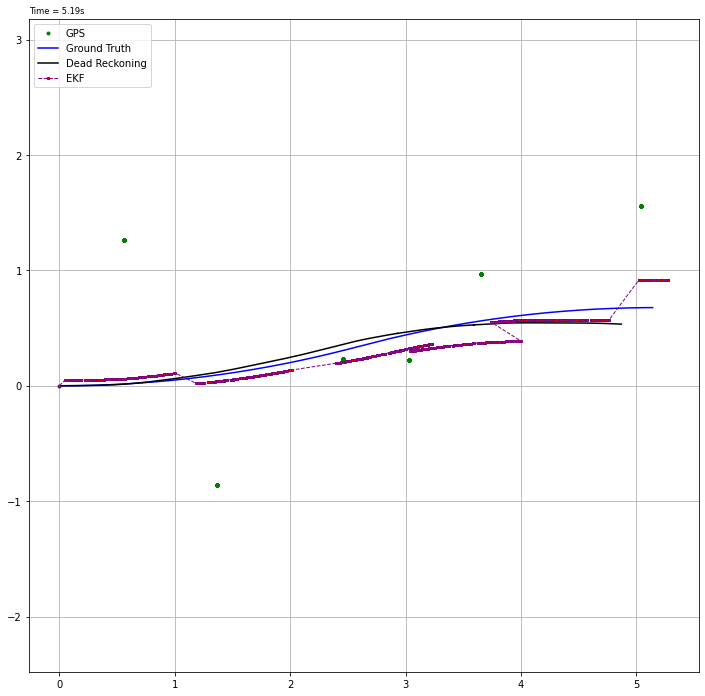

In [88]:
np.random.seed(0)
EKF_main(SIM_TIME = run_time, show_animation = True, show_covarience = False)

Number of iterations per update: 
 [2, 2, 2, 2, 2, 2]


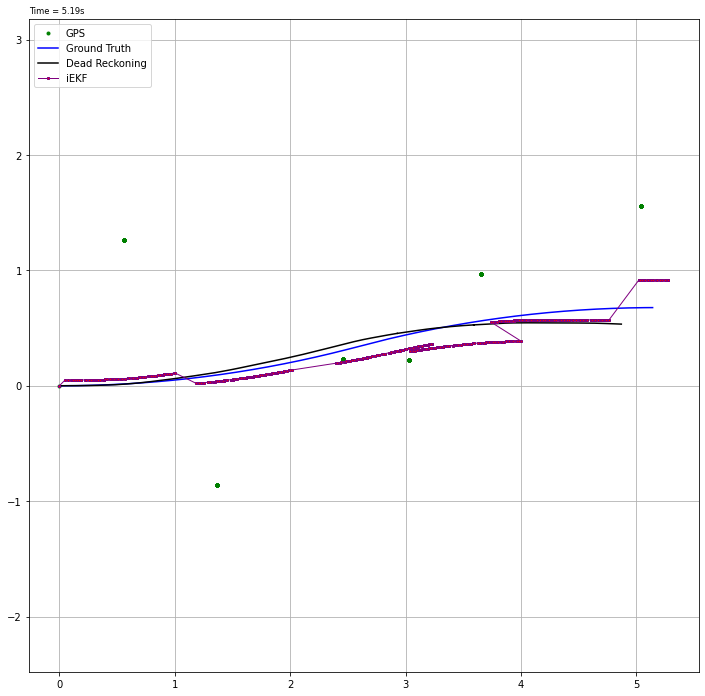

In [89]:
np.random.seed(0)
iEKF_main(SIM_TIME = run_time, show_animation = True, show_covarience = False, max_iter=100)

# lets change noise level for gps (and adjusting R)
"Implement the EKF and present the effect of increasing noise in angular rate and linear accceleration as well as in **position measurements**."

In [90]:
run_time = 5.2 #seconds
# noise
ODOM_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
GPS_NOISE = np.diag([0.75, 0.75]) ** 2
R = (15.0 * np.diag([1.0, 1.0])) ** 2  # Observation x,y position covariance

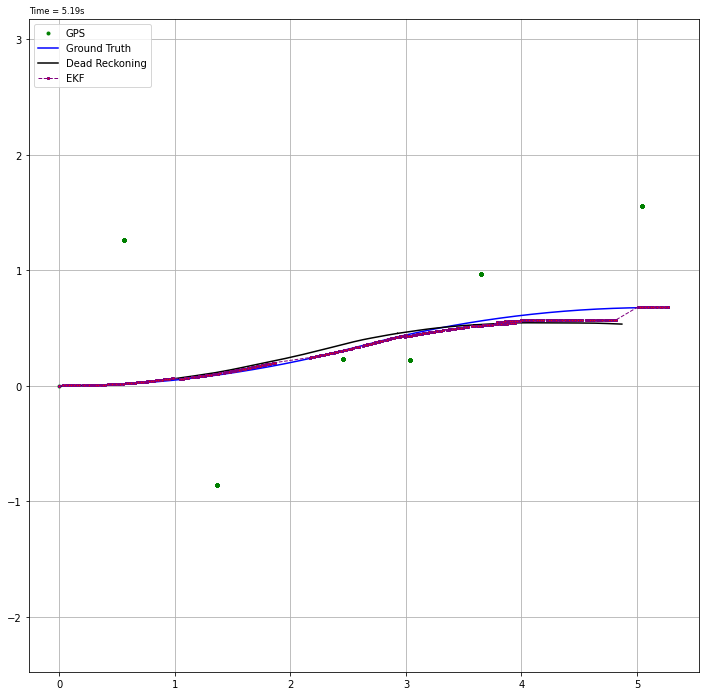

In [91]:
np.random.seed(0)
EKF_main(SIM_TIME = run_time, show_animation = True, show_covarience = False)

Number of iterations per update: 
 [2, 2, 2, 2, 2, 2]


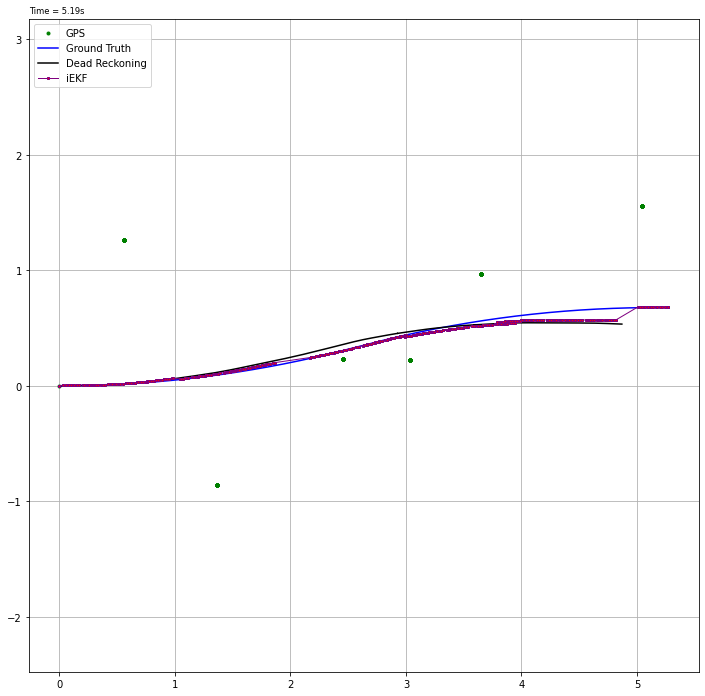

In [92]:
np.random.seed(0)
iEKF_main(SIM_TIME = run_time, show_animation = True, show_covarience = False, max_iter=100)

# comments
- ekf/iekf performs better when we adjust Observation Covarience with accordance to the noise level(more noise= more variance).
- As we can see, the iEKF does not perform very differently than EKF in this particular case. This is due to the fact that we are not essentially linearizing the "update" iteratively as our position measurements directly gives us position states. So the iterative linearization loop exits after only 2 iterations!

- We would see more stark difference in case of gyro-accelarometer fusion where accelarometer readings could be the update while gyro would be the predict, and we would need to linearize both of them. in this case, we would iteratively compute jacobian of the accelarometer reading and see the difference between **EKF vs IEKF** .

# EKF with long duration
now we can see the benifit of sensor fusion. even though our dead reconing is drifting, even with a noisy position update, we are very close to the ground truth

In [97]:
run_time = 30.2 #seconds
#default noise
ODOM_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
GPS_NOISE = np.diag([0.2, 0.2]) ** 2

R = (5.0 * np.diag([1.0, 1.0])) ** 2  # Observation x,y position covariance

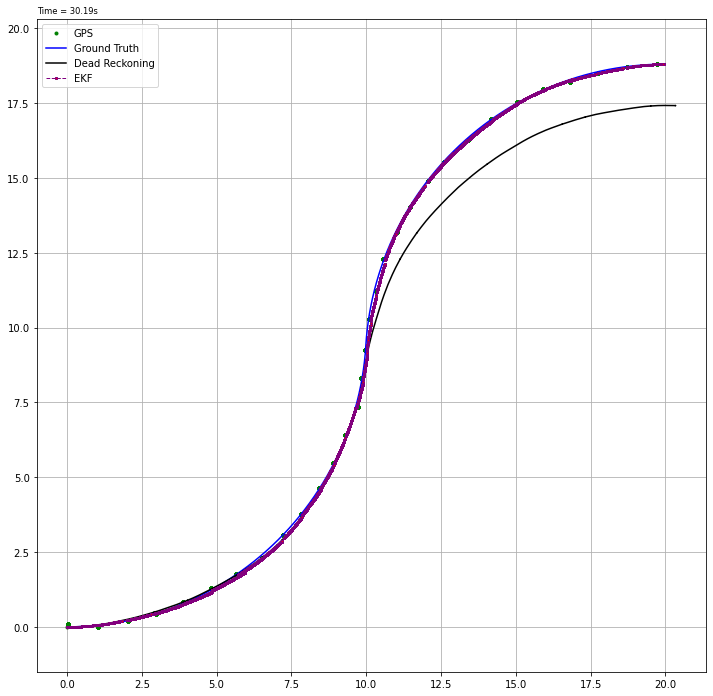

In [99]:
np.random.seed(0)
EKF_main(SIM_TIME = run_time, show_animation = True, show_covarience = False)